In [ ]:
import ee
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

! pip install -U plotnine
import plotnine
from plotnine import *

! pip install rasterio
import rasterio

import itertools
import difflib
import sys
import os
import requests
from tqdm.auto import tqdm
from pprint import pprint

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

In [2]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

Mounted at /content/G_drive


In [3]:
# change dir, append sys_path, and import custom moduls
cwd = '/content/G_drive/MyDrive/Colab Notebooks/Paper_3/Earth_Engine_codes/Step_3_Scenarios'
os.chdir(cwd)
sys.path.append('../Step_2_Sort_GAEZ_layers')


from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [4]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# import NCL shp
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")
NCP_cities = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

## 1. Compute yield conversion ratio

- For maize, it's 0.87.
- For wetland rice it's 0.875 (0.9 for dryland rice)
- For wheat it's 0.875. 

#### Load yield data from [ 'Actual', 'Yearbook']

In [5]:
# get the GAEZ total production and yearbook records
GAEZ_yearbook_2010_comparision = pd.read_csv('../Step_2_Sort_GAEZ_layers/result_csv/Validata_GAEZ_yearbook.csv')
GAEZ_yearbook_2010_comparision = GAEZ_yearbook_2010_comparision.dropna().reset_index()
GAEZ_yearbook_2010_comparision = GAEZ_yearbook_2010_comparision[GAEZ_yearbook_2010_comparision['crop'].isin(['Wheat','Maize','Wetland_rice'])]
GAEZ_yearbook_2010_comparision = GAEZ_yearbook_2010_comparision[[ 'crop', 'water','City', 'GAEZ', 'Yearbook']]

# divide value by 1000 to match the GAEZ unit (kt)
GAEZ_yearbook_2010_comparision[['GAEZ','Yearbook']] = GAEZ_yearbook_2010_comparision[['GAEZ','Yearbook']]/1000

GAEZ_yearbook_2010_comparision.head()

,crop,water,City,GAEZ,Yearbook
0,Maize,Total,巢湖市,31.977072,26.349
1,Maize,Total,承德市,1327.226039,906.995
2,Maize,Total,淮北市,262.498089,237.141
3,Maize,Total,郑州市,962.252080,737.733
4,Maize,Total,周口市,1644.791679,1814.654


#### Load yield data from [ 'Attainable']

In [6]:
# get the historical_attainable_yield
interpolate_df_full = pd.read_pickle('../Step_2_Sort_GAEZ_layers/result_csv/attainable_yield_interpolated.pkl')

attainable_historical = interpolate_df_full[[str(i) in (['1975','1985','1995','2010']) for i in interpolate_df_full['year'].tolist()]]
attainable_historical = attainable_historical.drop(['img_future_sd','img_future_ci'],1)

attainable_historical_2010 = attainable_historical[attainable_historical['year']==2010]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [7]:
stats_dfs = []
# compute the total attainable in each city
for idx,row in tqdm(attainable_historical_2010.iterrows(),total=len(attainable_historical_2010)):

  # get data from each row
  img = row['image']
  crop = row['crop']
  water = row['water']

  # compute stats in GEE
  stats = img.reduceRegions(reducer='sum',scale=GAEZ_pix_scale,collection=NCP_cities).getInfo()
  stats_df = pd.DataFrame([i['properties'] for i in stats['features']])

  # organize the stats_df
  stats_df['crop'] = crop
  stats_df['water'] = water
  stats_df['City'] = stats_df['CityNameC']
  stats_df['Attainable'] = stats_df['sum']

  stats_df = stats_df[['crop','water','City','Attainable']]
  stats_dfs.append(stats_df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
# concat all dfs
attainable_production_2010 = pd.concat(stats_dfs)

# remove Rainfed Wetland_rice because no such crop was planted in the research area
attainable_production_2010 = attainable_production_2010[~((attainable_production_2010['crop'] == 'Wetland_rice')&
                               (attainable_production_2010['water'] == 'Rainfed'))]

# compute the total production
attainable_production_2010 = attainable_production_2010.groupby(['crop','City']).sum().reset_index()
attainable_production_2010.head()

,crop,City,Attainable
0,Maize,三门峡市,2.502791e+06
1,Maize,东营市,1.321907e+06
2,Maize,临沂市,5.259141e+06
3,Maize,亳州市,2.537876e+06
4,Maize,保定市,5.439094e+06


#### Combine [Attainable, Actual, Yearbook]

In [10]:
def conversion(crop,in_val):

  if in_val == 'Maize':
    return in_val*0.87
  else:
    return in_val*0.875

In [13]:
Attainable_Actual_Yearbook_df = GAEZ_yearbook_2010_comparision.merge(attainable_production_2010,on=['crop','City'])
Attainable_Actual_Yearbook_df['Attainable_convert'] = Attainable_Actual_Yearbook_df.apply(lambda x:conversion(x['crop'],x['Attainable'])/1000,1)

Attainable_Actual_Yearbook_df

,crop,water,City,GAEZ,Yearbook,Attainable,Attainable_convert
0,Maize,Total,承德市,1327.226039,906.995,6.175164e+06,5403.268397
1,Maize,Total,淮北市,262.498089,237.141,8.104653e+05,709.157131
2,Maize,Total,郑州市,962.252080,737.733,2.152284e+06,1883.248461
3,Maize,Total,周口市,1644.791679,1814.654,3.481743e+06,3046.524773
4,Maize,Total,合肥市,118.427857,78.334,2.642089e+06,2311.828005
...,...,...,...,...,...,...,...
162,Wheat,Total,安阳市,1074.851762,1863.514,1.122271e+06,981.986782
163,Wheat,Total,宿州市,834.521901,2295.520,2.027526e+06,1774.085408
164,Wheat,Total,洛阳市,1086.607742,1108.242,2.978231e+06,2605.952468
165,Wheat,Total,南阳市,2404.203092,3576.332,5.384630e+06,4711.550984


#### Plot the convertion ratio

In [19]:
# reshape the df for convinient plot
Attainable_Actual_Yearbook_df_stack = pd.DataFrame(Attainable_Actual_Yearbook_df.
                            set_index(['crop', 'water', 'City', 'GAEZ', 'Yearbook', 'Attainable'])\
                      .stack()).reset_index()
Attainable_Actual_Yearbook_df_stack = Attainable_Actual_Yearbook_df_stack.rename(columns={'level_6':'Source',0:'val'})

Attainable_Actual_Yearbook_df_left = Attainable_Actual_Yearbook_df_stack[Attainable_Actual_Yearbook_df_stack['Source']=='GAEZ_ratio']
Attainable_Actual_Yearbook_df_right = Attainable_Actual_Yearbook_df_stack[Attainable_Actual_Yearbook_df_stack['Source']=='Yearbook_ratio']

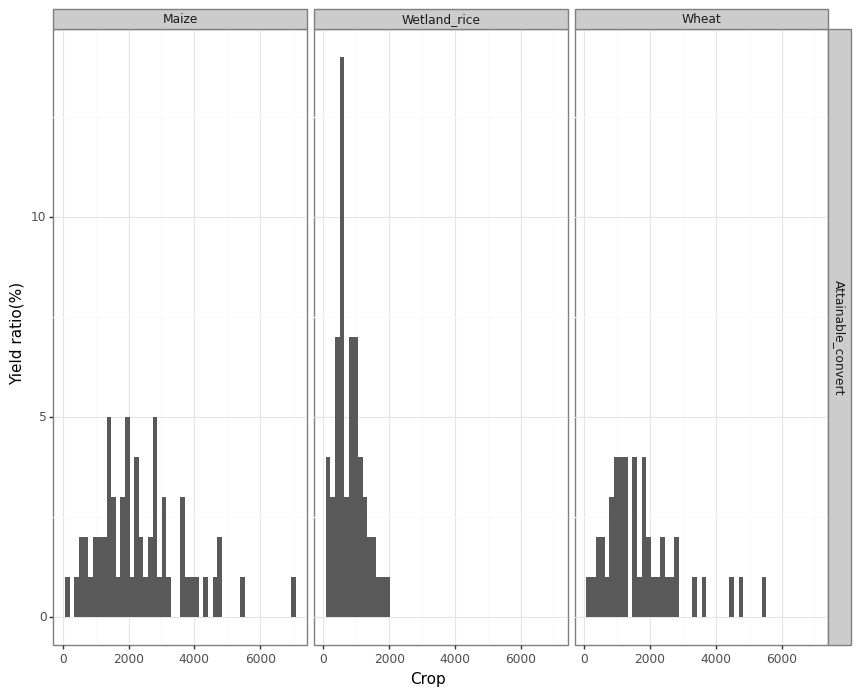

<ggplot: (8778133345361)>

In [20]:
plotnine.options.figure_size = (10, 8)
plotnine.options.dpi = 100

(ggplot(data=Attainable_Actual_Yearbook_df_stack)+
 geom_histogram(aes(x='val'),bins = 50) +
 facet_grid('Source~crop') +
 theme_bw() +
 xlab('Crop')+
 ylab('Yield ratio(%)')
 )

In [18]:
plotnine.options.figure_size = (10, 8)
plotnine.options.dpi = 100

(ggplot()+
 geom_violin(aes(x='crop', y='val',fill='Source'),data=Attainable_Actual_Yearbook_df_left, style='left', color='grey',alpha=1/3) +
 geom_violin(aes(x='crop', y='val',fill='Source'),data=Attainable_Actual_Yearbook_df_right, style='right',color='grey',alpha=1/3) +
 theme_bw() +
 scale_fill_manual(values=['#db5f57','#57d3db'])+
 xlab('Crop')+
 ylab('Yield ratio(%)')
 )

IndexError: ignored

### Determine the convertion ratio (attianable yield (kg DW)--> yield (kt) )

In [ ]:
# find out how many city names are missing
names_shp = [i['properties']['CityNameC'] for i in NCP_cities.getInfo()['features']]
names_csv = Attainable_Actual_Yearbook_df['City'].unique()

# print out the missing value: Because we do not have the city-level records in Jiangsu province
set(names_shp) - set(names_csv)

{'南京市',
 '南通市',
 '宿迁市',
 '常州市',
 '徐州市',
 '扬州市',
 '无锡市',
 '泰州市',
 '淮安市',
 '盐城市',
 '苏州市',
 '荷泽市',
 '连云港市',
 '镇江市'}

In [ ]:
# load the actual yeild of 2010
actual_yield_2010 = get_img_df(img_path = GAEZ_list,
                theme = 'GAEZ_5',
                variable = ['Yield'],
                time = '2010',
                crop = ['Maize','Wetland_rice','Wheat'],
                water = ['Rainfed','Irrigated'])

# merge actual and attainable yeild
actual_attainable_GAEZ = actual_yield_2010.merge(attainable_historical_2010,on=['crop','water'])
actual_attainable_GAEZ = actual_attainable_GAEZ[['crop','water','GEE_path','image']]

# compute the convertion ratio
actual_attainable_GAEZ['ratio'] = actual_attainable_GAEZ.apply(lambda x: ee.Image(x['GEE_path']).divide(x['image']),1)

In [ ]:
# function to get array from GEE raster
def get_arr(in_df):

  df_list = []

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    name = f"{row['crop']}_{row['water']}"
    img = ee.Image(row['ratio']).clip(NCP_shp)
    
    url = img.getDownloadURL(dict(name=name,format='GEO_TIFF',scale=GAEZ_pix_scale,region=NCP_shp.geometry()))

    # download tif
    res = requests.get(url).content
    
    with open(f'/content/{name}.tif','wb') as f:
      f.write(res)
    
    # open rater
    ds = rasterio.open(f'/content/{name}.tif')
    ds_arr = ds.read()

    # save arrary as df
    arr_df = pd.DataFrame(ds_arr.reshape([-1]))
    arr_df.columns = ['val']

    # remove outliers
    bot,up = np.quantile(arr_df['val'],(0.01,0.99))
    arr_df = arr_df[(arr_df['val'] > bot)&
              (arr_df['val'] < up)]

    arr_df['crop'] = row['crop']
    arr_df['water'] = row['water']
    
    # store df
    df_list.append(arr_df)

  return pd.concat(df_list).reset_index(drop=True)

In [ ]:
# get ratio df
ratio_df = get_arr(actual_attainable_GAEZ)

# change the col datatypes
ratio_df['val'] = ratio_df['val'].astype('float')
ratio_df['water'] = ratio_df['water'].astype('category')
ratio_df['crop'] = ratio_df['crop'].astype('category')

# get ratio of Rainfed
ratio_df_rainfed = ratio_df[ratio_df['water']=='Rainfed']
ratio_df_irrigated = ratio_df[ratio_df['water']=='Irrigated']

  0%|          | 0/6 [00:00<?, ?it/s]

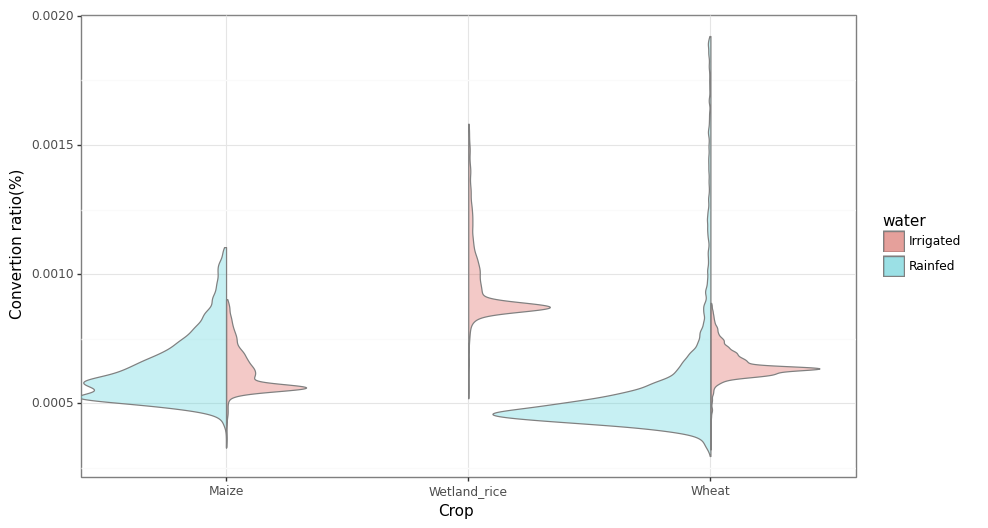

<ggplot: (8779315173089)>

In [ ]:
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 100

(ggplot()+
 geom_violin(aes(x='crop', y='val',fill='water'),data=ratio_df_rainfed, style='left', color='grey',alpha=1/3) +
 geom_violin(aes(x='crop', y='val',fill='water'),data=ratio_df_irrigated, style='right',color='grey',alpha=1/3) +
 theme_bw() +
 scale_fill_manual(values=['#db5f57','#57d3db'])+
 xlab('Crop')+
 ylab('Convertion ratio(%)')
 )

## 2. Convert GAEZ attainable yield (kg DW/ha) to actual yield (kt/ha)

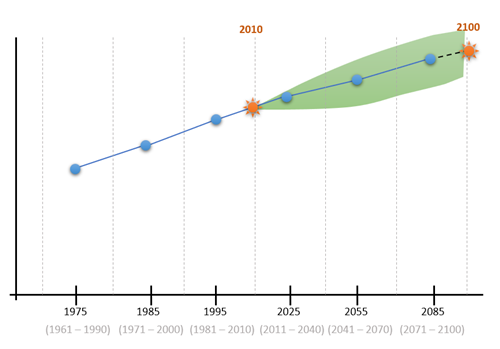

In [21]:
# actual harvested area
actual_area = get_img_df(img_path = GAEZ_list,
              theme = 'GAEZ_5',
              variable = ['Harvested_area'],
              time = '2010',
              crop = ['Maize','Wetland_rice','Wheat'],
              water = ['Rainfed','Irrigated'])

# get the area ratio for Rainfed/Irrigated, the ratio will be used as weights
# to compute: mean_yield = (crop_rainfed)*(rainfed_ratio) + (crop_irrigated*irrigated_ratio)
def compute_area_ratio(row):

  crop = row['crop']
  water = row['water']
  img = ee.Image(row['GEE_path'])
  
  # note the Rainfed Wetland_rice is not avaliable in actual yield,
  # so we exclude it here
  if crop == 'Wetland_rice':
    if water == 'Rainfed':
      return ee.Image(0)
    else:
      return ee.Image(1)

  img_areas = [ee.Image(i) for i in actual_area[actual_area['crop']==crop]['GEE_path'].tolist()]
  img_total_area = ee.ImageCollection(img_areas).sum()
  img_area_ratio = img.divide(img_total_area)

  return img_area_ratio


# get the crop area ratio for different water type
actual_area['area_ratio'] = actual_area.apply(lambda row:compute_area_ratio(row),1)
actual_area = actual_area[['crop','water','area_ratio']]

In [22]:
# get the critical years
attainable_anchors = interpolate_df_full[[str(i) in (['1975','1985','1995','2010','2025','2055','2085','2100']) 
                          for i in interpolate_df_full['year'].tolist()]]

# remove Rainfed Wetland_rice since this crop never shows in the actual yield records
attainable_anchors = attainable_anchors[~((attainable_anchors['crop']=='Wetland_rice')&
                       (attainable_anchors['water']=='Rainfed'))].reset_index(drop=True)

In [23]:
# function to get attianable yield for each province
def get_attainable(in_df):

  # hack to show progress bar
  print(' ',end='',flush=True)

  df_list = []

  # compute the total attainable yield in each provinces
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    water = row['water']
    year = row['year']
    rcp = row['rcp']

    img_val = row['convert_actual_yield_val'].rename('val')
    img_ds = row['convert_actual_yield_sd'].rename('sd')
    img = ee.Image([img_val,img_ds])
    # compute stats from GEE
    stats = img.reduceRegions(collection=NCP_shp,reducer='mean',scale=GAEZ_pix_scale).getInfo()   
    # get data
    stats_df = pd.DataFrame({i['properties']['NAME']:[i['properties']['val']] for i in stats['features']}).T
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']]

    # append infomation
    stats_df = stats_df.reset_index()
    stats_df.columns=['Province','Mean Production','sd']
    stats_df['water'] = water
    stats_df['crop'] = crop
    stats_df['year'] = year
    stats_df['rcp'] = rcp

    stats_df['top'] = stats_df['Mean Production'] + stats_df['sd']
    stats_df['bot'] = stats_df['Mean Production'] - stats_df['sd']

    # CN to EN
    stats_df['Province'] = stats_df.apply(lambda x:city_cn_en[x['Province']],1)

    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list).reset_index(drop=True)
  
  return out_df

In [ ]:
#################### link attainable with convertion ratio ##################### 
anchor_actual_province = attainable_anchors.merge(actual_attainable_GAEZ,on=['crop','water']).fillna(0)

# compute the actual yield converted from attainable yield
anchor_actual_province['convert_actual_yield_val'] = anchor_actual_province.apply(lambda x:x['image_x'].multiply(x['ratio']),1)
anchor_actual_province['convert_actual_yield_sd'] = anchor_actual_province.apply(lambda x:ee.Image(x['img_future_sd']).multiply(x['ratio']),1)

# keep only usefull columns
anchor_actual_province = anchor_actual_province[['crop','water','rcp','year','convert_actual_yield_val','convert_actual_yield_sd']]


##################### Multiply each crop_water with its area_ratio #############
anchor_actual_province = anchor_actual_province.merge(actual_area,on=['crop','water'])

# compute the area_weighted actual yield
anchor_actual_province['convert_actual_yield_val'] = anchor_actual_province.apply(lambda x:x['convert_actual_yield_val'].multiply(x['area_ratio']),1)
anchor_actual_province['convert_actual_yield_sd'] = anchor_actual_province.apply(lambda x:ee.Image(x['convert_actual_yield_sd']).multiply(x['area_ratio']),1)


#################### Get the mean production for each province ###########################
anchor_actual_province_stats = parallelize_dataframe(anchor_actual_province,get_attainable,10)

# sum rainfed/irrigated together
anchor_actual_province_stats_aggregate_water = anchor_actual_province_stats.groupby(['crop','Province','year','rcp']).sum().reset_index()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

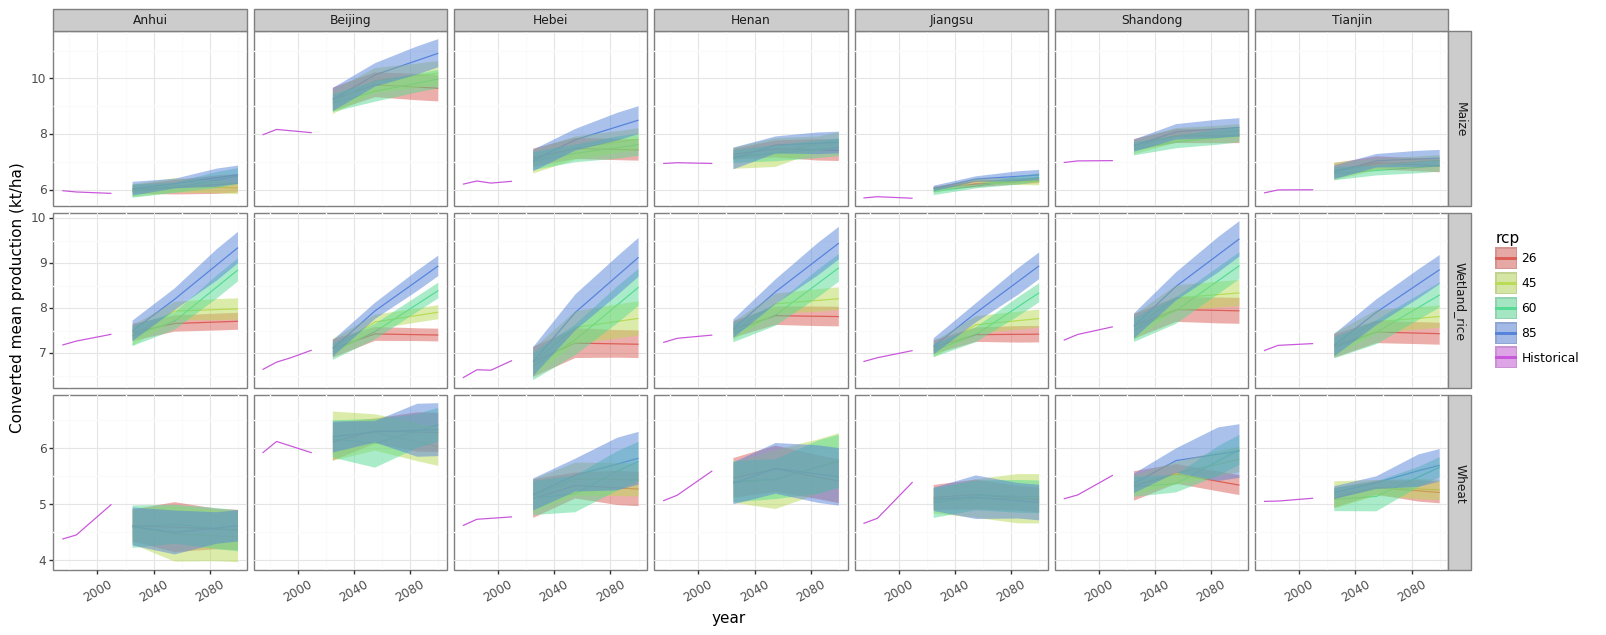

<ggplot: (8779327223829)>

In [ ]:
plotnine.options.figure_size = (18, 7)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(anchor_actual_province_stats_aggregate_water, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(anchor_actual_province_stats_aggregate_water, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Converted mean production (kt/ha)')
)

Seeing above historical attainbale-yield, we can conclude that the historical climate change has less impcats to crop yield. This conclusion is very strange as we know the climate change since 1980 was also siginificant. I assume two reasons led to such result:
- The historical GAEZ data is bad, which lead to unreasonable results
- The historical climate change (1975-2010) is not so significant compared to current magnitude.

#### Get the actual production from yearbook

In [ ]:
# function to read yearbook csv and orginize data
def read_csv(path,crop):

  # read and reshape data to long format
  df = pd.read_csv(path)
  df = df.set_index('地区')
  df = df.stack().reset_index()
  df.columns = ['Province','year','Mean Production']
  df['year'] = df['year'].apply(lambda x: int(x[:4]))
  df['crop'] = crop

  # fitler df and replace CN to EN
  df = df[df['Province'].isin(city_cn_en.keys())]
  df = df.replace(city_cn_en)

  # remove 0s
  df = df[df['Mean Production']!=0]

  return df

In [ ]:
# read data and concat to a single df
wheat_yield_history = read_csv('../../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_wheat_yield.csv','Wheat')
rice_yield_history = read_csv('../../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_rice_yield.csv','Wetland_rice')
maize_yield_history = read_csv('../../Data/06_Yearbook/Agricultural_production/Provincial_historical_yield/Provincial_maize_yield.csv','Maize')

crop_yield_history = pd.concat([wheat_yield_history,rice_yield_history,maize_yield_history]).reset_index(drop=True)

# filter the yearbook records to perform regresion
crop_yield_history = crop_yield_history[crop_yield_history['year']>1975]

# convert t/ha to kt/ha, so the uint is consistent with GAEZ
crop_yield_history['Mean Production'] = crop_yield_history['Mean Production']/1000
crop_yield_history['rcp'] = 'Yearbook'

In [ ]:
# linear regression to fit yearbook data

pred_dfs = []
regressions = []

# fit a linear model to each of zone/crop combination
for zone in tqdm(crop_yield_history['Province'].unique()):
  for crop in crop_yield_history['crop'].unique():

    df = crop_yield_history[(crop_yield_history['Province']==zone)&(crop_yield_history['crop']==crop)]

    # built the linear regression
    y = df['Mean Production']
    X = df['year']

    # add a constant column to X, so to get intercept
    X = sm.add_constant(X)

    # construct the model
    mod = sm.OLS(y, X)
    res = mod.fit()
    R2 = res.rsquared_adj

    # record the regression given each Zone/crop
    regressions.append((zone,crop,res.params['const'],res.params['year'],res.rsquared_adj))

    # make predictions with ci

    # 1) preapare input data
    year_in = sorted(crop_yield_history['year'].unique())
    X_in = pd.DataFrame({'year':year_in})
    X_in = sm.add_constant(X_in)

    # 2) get prediction
    pred_df = res.get_prediction(X_in).summary_frame(alpha=0.05)

    # 3) append infos
    pred_df['year'] = year_in

    pred_df['Province'] = zone
    pred_df['crop'] = crop

    # record df
    pred_dfs.append(pred_df)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# get predicted yeild
pred_df_cat = pd.concat(pred_dfs).reset_index(drop=True)
pred_df_cat['rcp'] = 'Yearbook'

# filter records for plotting
crop_yield_history_1975_2020 = crop_yield_history[(crop_yield_history['year']<2020)&(crop_yield_history['year']>=1975)]

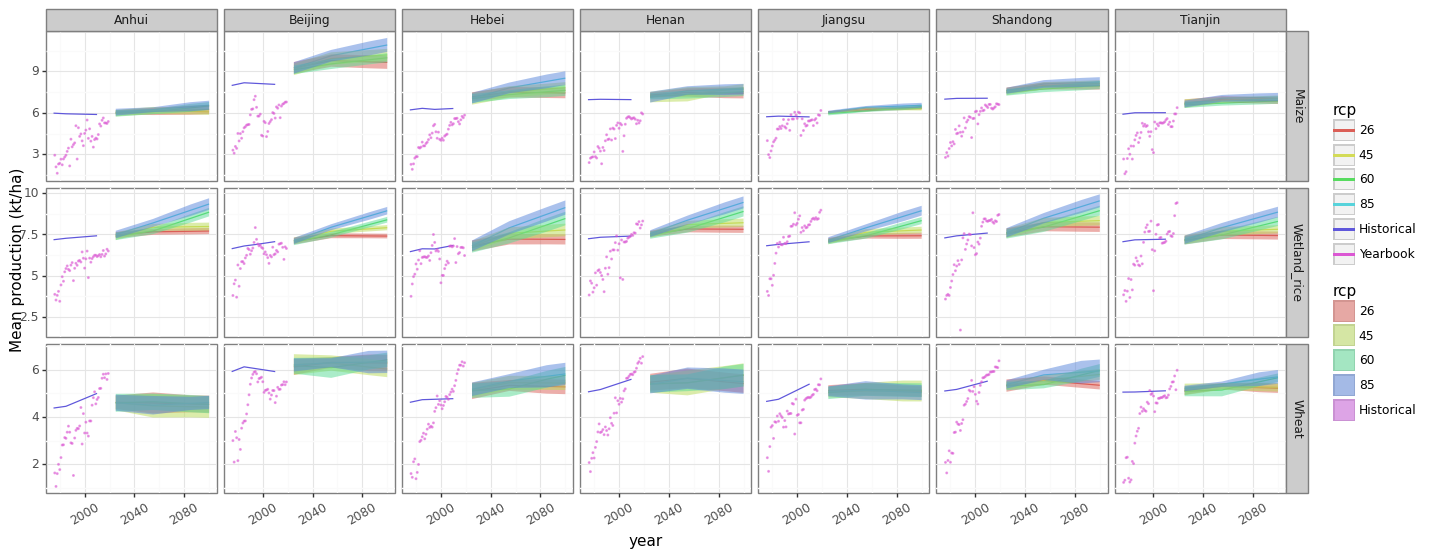

<ggplot: (8779322401477)>

In [ ]:
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 
 geom_line(anchor_actual_province_stats_aggregate_water, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(anchor_actual_province_stats_aggregate_water, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +

 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
#  geom_line(pred_df_cat, aes('year','mean',color='rcp')) +
#  geom_ribbon(pred_df_cat, aes('year',ymin='obs_ci_lower',ymax='obs_ci_upper',fill='rcp'),alpha=0.3) +
  facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Mean production (kt/ha)')
)

#### Force the GAEZ data to be the same with yearbook records by sutracting constant

In [ ]:
# get the difference between GAEZ and Yearbook records
anchor_actual_province_stats_aggregate_water_2010 = anchor_actual_province_stats_aggregate_water[anchor_actual_province_stats_aggregate_water['year']==2010]

GAEZ_yearbook_diff = anchor_actual_province_stats_aggregate_water_2010.merge(crop_yield_history_1975_2020,on=['crop','Province','year'])
GAEZ_yearbook_diff['GAEZ_yearbook_delta'] = GAEZ_yearbook_diff['Mean Production_x'] - GAEZ_yearbook_diff['Mean Production_y']
GAEZ_yearbook_diff = GAEZ_yearbook_diff[['crop','Province','GAEZ_yearbook_delta']]

In [ ]:
# # get the difference between GAEZ and Yearbook records
# crop_yield_history_moving_average = crop_yield_history.copy()
# crop_yield_history_moving_average['moving_mean'] = crop_yield_history_moving_average['Mean Production'].rolling(10).mean()

# anchor_actual_province_stats_aggregate_water_2010 = anchor_actual_province_stats_aggregate_water[anchor_actual_province_stats_aggregate_water['year']==2010]

# GAEZ_yearbook_diff = anchor_actual_province_stats_aggregate_water_2010.merge(crop_yield_history_moving_average,on=['crop','Province','year'])
# GAEZ_yearbook_diff['GAEZ_yearbook_delta'] = GAEZ_yearbook_diff['Mean Production_x'] - GAEZ_yearbook_diff['moving_mean']
# GAEZ_yearbook_diff = GAEZ_yearbook_diff[['crop','Province','GAEZ_yearbook_delta']]

In [ ]:
# # get the difference between GAEZ and Yearbook records
# anchor_actual_province_stats_aggregate_water_2010 = anchor_actual_province_stats_aggregate_water[anchor_actual_province_stats_aggregate_water['year']==2010]

# GAEZ_yearbook_diff = anchor_actual_province_stats_aggregate_water_2010.merge(pred_df_cat,on=['crop','Province','year'])
# GAEZ_yearbook_diff['GAEZ_yearbook_delta'] = GAEZ_yearbook_diff['Mean Production'] - GAEZ_yearbook_diff['mean']
# GAEZ_yearbook_diff = GAEZ_yearbook_diff[['crop','Province','GAEZ_yearbook_delta']]

In [ ]:
# empty list to hold list
names_col = []
vals_col = []
sds_col = []

for idx,row in anchor_actual_province.iterrows():
  # get val/sd img
  img_val = row['convert_actual_yield_val']
  rcp = row['rcp']

  # empty list to hold results
  names = []
  vals = []

  # loop through provinces, clip the img
  for k,v in city_cn_en.items():
    shp = NCP_shp.filter(ee.Filter.equals('NAME',k))
    img_cliped_val = img_val.clip(shp)

    names.append(v)
    vals.append(img_cliped_val)

  # append list to list
  names_col.append(names)
  vals_col.append(vals)

In [ ]:
################################ append cliped imgs ######################################
anchor_actual_province_clip = anchor_actual_province.copy()
anchor_actual_province_clip[['Province','convert_actual_yield_val_clip']] = pd.DataFrame(zip(names_col,vals_col))

# keep only necessary cols
anchor_actual_province_clip = anchor_actual_province_clip[['crop','water','rcp','year','Province','convert_actual_yield_val_clip','convert_actual_yield_sd']]
anchor_actual_province_clip = anchor_actual_province_clip.rename(columns={'convert_actual_yield_val_clip':'convert_actual_yield_val'})
anchor_actual_province_clip = anchor_actual_province_clip.explode(['Province','convert_actual_yield_val'])

# ################################ subtract the delta ######################################
# link the anchor_actual_province_clip with diff_df 
anchor_actual_province_subtract = anchor_actual_province_clip.merge(GAEZ_yearbook_diff,on=['crop','Province'])
anchor_actual_province_subtract['convert_actual_yield_subtracted'] = anchor_actual_province_subtract\
                                .apply(lambda x:x['convert_actual_yield_val'].subtract(ee.Image(x['GAEZ_yearbook_delta'])),1)


################################ mosaic clip_imgs back to whole ######################################
# mosaic image_clips
mosaic_imgs = pd.DataFrame(anchor_actual_province_subtract.groupby(['crop','water','rcp','year'])\
            .apply(lambda df,idx:ee.ImageCollection(df['convert_actual_yield_subtracted'].tolist()).mosaic(),1))\
            .reset_index()

# append the mosaiced imgs back to df
anchor_actual_province_adj = anchor_actual_province.copy()
anchor_actual_province_adj = anchor_actual_province_adj.merge(mosaic_imgs,on=['crop','water','rcp','year'])
anchor_actual_province_adj['convert_actual_yield_val'] = anchor_actual_province_adj[0]

In [ ]:
##################### Multiply each crop_water with its area_ratio #############
# compute the area_weighted actual yield
anchor_actual_province_adj['convert_actual_yield_val'] = anchor_actual_province_adj.apply(lambda x:x['convert_actual_yield_val'].multiply(x['area_ratio']),1)
anchor_actual_province_adj['convert_actual_yield_sd'] = anchor_actual_province_adj.apply(lambda x:ee.Image(x['convert_actual_yield_sd']).multiply(x['area_ratio']),1)


#################### Get the mean production for each province ###########################
anchor_actual_province_adj_stats = parallelize_dataframe(anchor_actual_province_adj,get_attainable,10)

# sum rainfed/irrigated together
anchor_actual_province_adj_stats_aggregate_water = anchor_actual_province_adj_stats.groupby(['crop','Province','year','rcp']).sum().reset_index()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

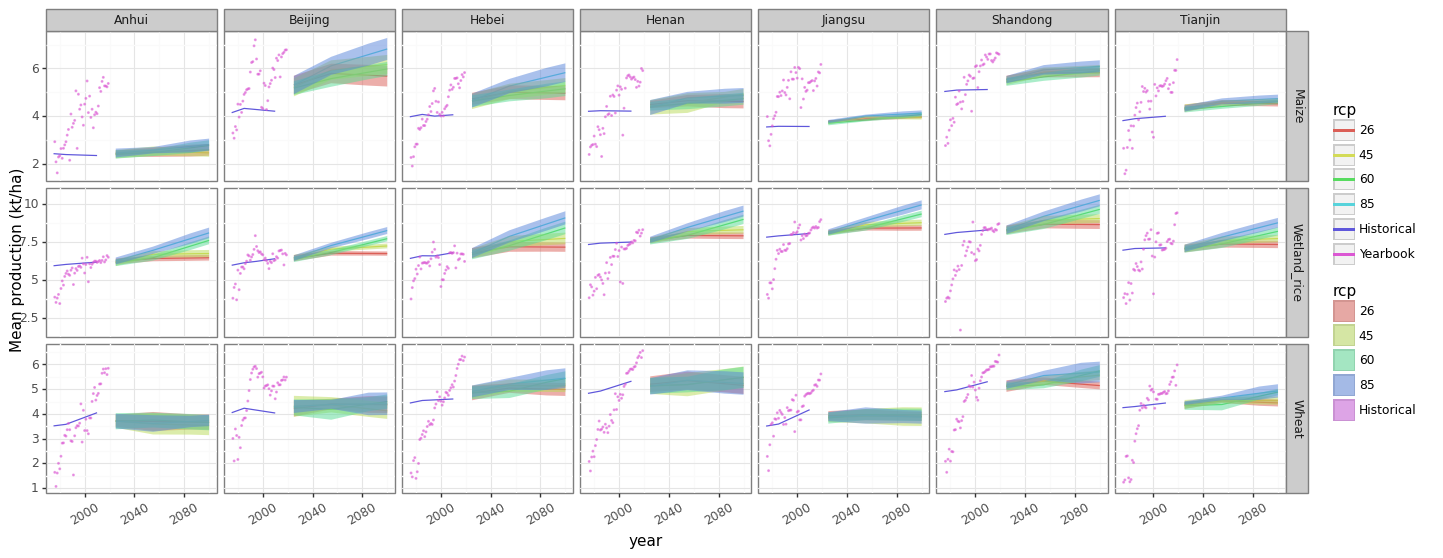

<ggplot: (8779308566909)>

In [ ]:
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(anchor_actual_province_adj_stats_aggregate_water, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(anchor_actual_province_adj_stats_aggregate_water, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Mean production (kt/ha)')
)